# Import Drivers+, Download Overlay

In [228]:
import logging
import sys
import pynq
import time
from pynq import PL, buffer

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc, trigger
#from mkidgen3.drivers.ifboard import IFBoard
from mkidgen3.testutils import *
import xrfclk
import xrfdc
from pynq import Overlay

In [229]:
import logging

In [230]:
logging.basicConfig()

In [231]:
# Download Overlay, Optionally Configure Clocks
bitstream='photon_captest4.bit'
#bitstream='gen3_top.bit'
ol = g3.overlay_helpers.configure(bitstream, ignore_version=True, clocks=False, programming_key='4.096GSPS_MTS', download=True)

# Interrupts

In [266]:
ol.trigger_system.photon_maxi_0.interrupt

In [318]:
ol.trigger_system.photon_maxi_0.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=1, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=1, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  photons_out_1 = Register(photons_out=2102394880),
  photons_out_2 = Register(photons_out=0),
  Memory_n_photons = Register(value=0),
  active_buffer = Register(active_buffer=0, RESERVED=0),
  active_buffer_ctrl = Register(active_buffer_ap_vld=1, RESERVED=0),
  photons_per_buf = Register(photons_per_buf=65535, RESERVED=0),
  time_shift = Register(time_shift=12, RESERVED=0)
}

In [127]:
async def wait_for_photon():
    ol.phase_in.tx(phases_in)
    await ol.trigger_system.photon_maxi_0.interrupt.wait()
    saved_data = ol.trigger_system.photon_maxi_0.get_photons()
    print(ol.trigger_system.photon_maxi_0.register_map)

In [128]:
import asyncio
loop = asyncio.get_event_loop()

In [129]:
task = loop.create_task(wait_for_photon())
loop.run_until_complete(task)

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0, INTERRUPT=1, RESERVED_3=0),
  GIER = Register(Enable=1, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=1, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=1, CHAN1_INT_ST=0, RESERVED_0=0),
  photons_out_1 = Register(photons_out=2033188864),
  photons_out_2 = Register(photons_out=0),
  Memory_n_photons = Register(value=2),
  active_buffer = Register(active_buffer=0, RESERVED=0),
  active_buffer_ctrl = Register(active_buffer_ap_vld=1, RESERVED=0),
  photons_per_buf = Register(photons_per_buf=65535, RESERVED=0),
  time_shift = Register(time_shift=12, RESERVED=0)
}


# Start IQ Values

In [233]:
ol.iq_gen_0.generate()

# Program Thresholds and Holdoffs

In [232]:
thresholds = -0.3*np.ones(2048)
holdoffs = (np.ones(2048)+8).astype(np.int16)
#holdoffs = holdoffs.astype(int).clip(0, 254)
thresholds, holdoffs

(array([-0.3, -0.3, -0.3, ..., -0.3, -0.3, -0.3]),
 array([9, 9, 9, ..., 9, 9, 9], dtype=int16))

In [234]:
ol.trigger_system.trigger_1.configure(thresholds, holdoffs)

## Generate Timestamps

In [196]:
x=(np.arange(70, dtype=np.uint64)*np.ones(512, dtype=np.uint64)[:,None]).T
x=x.reshape(np.prod(x.shape))+10
print(x[30:40])  # Should roll over from 35 to 0

# fifo is loaded 4 bytes at a time, stream is 5 bytes at a time, numbers here are 8 bytes at a time, 
# need to drop the bytes 5-7, keep 0-4, high 4 bits of byte 4 will be ignored
data=np.frombuffer(x, dtype=np.uint8).reshape((x.size,8))
needed_bytes=data[:,:5].ravel()
y=np.frombuffer(needed_bytes, dtype=np.uint32)
times_in=y

[10 10 10 10 10 10 10 10 10 10]


# Trick MAXI to Output Photon

In [236]:
x=(np.arange(70, dtype=np.uint64)*np.ones(512, dtype=np.uint64)[:,None]).T
x=x.reshape(np.prod(x.shape))+10

In [237]:
x[x.size//2:]+=20000
x[-512*3:]+=20000

# fifo is loaded 4 bytes at a time, stream is 5 bytes at a time, numbers here are 8 bytes at a time, 
# need to drop the bytes 5-7, keep 0-4, high 4 bits of byte 4 will be ignored
data=np.frombuffer(x, dtype=np.uint8).reshape((x.size,8))
needed_bytes=data[:,:5].ravel()
y=np.frombuffer(needed_bytes, dtype=np.uint32)
times_in=y

In [238]:
tmp=0

In [239]:
# Load timestamps in FIFO
tmp1=ol.timestamps_in.tx_vacancy
ol.timestamps_in.tx(times_in[tmp:tmp1])
tmp=tmp1

/home/xilinx/src/mkidgen3/mkidgen3/drivers/axififo.py:43: RuntimeWarning: coroutine 'Interrupt.wait' was never awaited
  self.interrupt.wait()  # wait for the transmit to complete


In [240]:
ol.timestamps_in.tx_vacancy

20744

# Configure Postage Filter

In [241]:
ol.trigger_system.postage_filter_0.configure(monitor_channels=[0,1,2,3,4,5,6,7])
ol.trigger_system.photon_maxi_0.capture();
ol.trigger_system.postage_maxi_0.capture();

In [242]:
#ol.trigger_system.photon_maxi_0.capture?

In [243]:
ol.trigger_system.postage_filter_0.register_map,\
ol.trigger_system.photon_maxi_0.register_map,\
ol.trigger_system.postage_maxi_0.register_map

(RegisterMap {
   monitor_0 = Register(monitor_0=0, RESERVED=0),
   monitor_1 = Register(monitor_1=1, RESERVED=0),
   monitor_2 = Register(monitor_2=2, RESERVED=0),
   monitor_3 = Register(monitor_3=3, RESERVED=0),
   monitor_4 = Register(monitor_4=4, RESERVED=0),
   monitor_5 = Register(monitor_5=5, RESERVED=0),
   monitor_6 = Register(monitor_6=6, RESERVED=0),
   monitor_7 = Register(monitor_7=7, RESERVED=0)
 },
 RegisterMap {
   CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
   GIER = Register(Enable=1, RESERVED=0),
   IP_IER = Register(CHAN0_INT_EN=1, CHAN1_INT_EN=0, RESERVED_0=0),
   IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
   photons_out_1 = Register(photons_out=2102394880),
   photons_out_2 = Register(photons_out=0),
   Memory_n_photons = Register(value=0),
   active_buffer = Register(active_buffer=0, RESERVED=0),
   active_buffer_ctrl = Register(active_buffer_ap_vld=0,

## Generate Phase Data

In [244]:
data = np.loadtxt('golden.dat', delimiter=' ', dtype=int)

In [245]:
phases = data[:,0]
trigger = data[:,1]
photon = data[:,2]
energy_val = data[:,3]

Reading back: Photon: [0:15] uint16 time [0:15] int16 phase [0:15] int16 resonator ID
Sending out: for a given channel (res ID)

In [246]:
x = phases+np.zeros((2048,1))
x[1:]=0
data_in = x.T.ravel().copy().astype(np.int16)
phases_in = np.frombuffer(data_in, dtype=np.uint32)

In [247]:
data_in

array([-459,    0,    0, ...,    0,    0,    0], dtype=int16)

In [248]:
# Load Phases
ol.phase_in.tx(phases_in)

In [255]:
ol.phase_in.tx_vacancy

65532

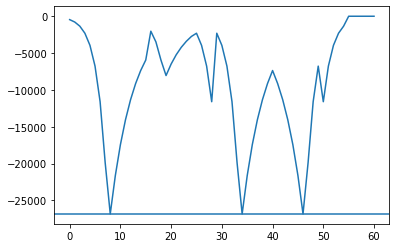

In [166]:
plt.plot(data_in[::2048])
plt.axhline(-26828)

In [253]:
self = ol.trigger_system.photon_maxi_0

# Should see two photons and we do

In [254]:
self.unpack_photons(self._buf[0])

array([(   18, -26828, 0), (20044, -26828, 0), (    0,      0, 0), ...,
       (    0,      0, 0), (    0,      0, 0), (    0,      0, 0)],
      dtype=[('time', '<u8'), ('phase', '<i2'), ('id', '<u2')])